# Outlier analysis with UMAP

The setup of this notebook is to transform the control data and color the UMAP scatter with the manual COI gate. The hypothesis is that UMAP will isolate the COIs

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# %load common_.py
from common import *

In [25]:
import umap
import dask.dataframe as dd
from ehv import core, load as e_load
from joblib import dump, load
from pathlib import Path

In [26]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=6, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38371 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 26.67 GB


In [27]:
client.cluster

In [28]:
reload(e_load)

<module 'ehv.load' from '/app/ehv/load.py'>

In [29]:
data_dd = e_load.load_raw_ideas_dir_dask(Path("/data/weizmann/EhV/high_time_res"), Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), "ALL", Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"))
data_dd = data_dd.map_partitions(e_load.remove_unwanted_features)
data_dd = data_dd.map_partitions(e_load.tag_columns)
data_dd = data_dd.persist()

In [30]:
data_dd.head().filter(regex="meta_.*")

,meta_Object Number,meta_Time,meta_Flow Speed,meta_timepoint,meta_replicate,meta_group,meta_label_COI,meta_label_MCP_NEG_PSBA_POS,meta_label_MCP_POS_PSBA_POS,meta_label_MCP_POS_PSBA_NEG,meta_label_MCP_NEG_PSBA_NEG
0,0,0.000000,43.123558,0,R1,Ctrl,False,False,False,False,False
1,1,0.001988,43.147675,0,R1,Ctrl,False,False,False,False,False
2,2,0.003687,43.147675,0,R1,Ctrl,False,False,False,False,False
3,3,0.007776,43.147675,0,R1,Ctrl,False,False,False,False,False
4,4,0.012374,43.147675,0,R1,Ctrl,False,False,False,False,False


# Ctrl samples

## 2D projection

In [32]:
def do_umap(data, **umap_args):
    projector = umap.UMAP(**umap_args)
    projection = projector.fit_transform(data.filter(regex="feat_.*"))
    projection = pandas.DataFrame(projection, columns=["dim_%d" % i for i in range(1, projector.get_params()["n_components"]+1)])
    return pandas.concat([data.filter(regex="meta_.*").reset_index(drop=True), projection], axis=1)

In [34]:
meta_df = data_dd.partitions[0].compute().filter(regex="meta_.*").head(0)
meta_df["dim_1"] = 0.0
meta_df["dim_2"] = 0.0
meta_df.head()

,meta_Object Number,meta_Time,meta_Flow Speed,meta_timepoint,meta_replicate,meta_group,meta_label_COI,meta_label_MCP_NEG_PSBA_POS,meta_label_MCP_POS_PSBA_POS,meta_label_MCP_POS_PSBA_NEG,meta_label_MCP_NEG_PSBA_NEG,dim_1,dim_2


In [12]:
%%time
projected = data_dd[data_dd["meta_group"] == "Ctrl"].groupby("meta_timepoint").apply(do_umap, n_components=2, meta=meta_df).compute()

CPU times: user 2min 23s, sys: 8.17 s, total: 2min 31s
Wall time: 5min 5s


In [14]:
dump(projected, "data/umap/HTR_Ctrl_ALL_pertp.dat")

['data/umap/HTR_Ctrl_ALL_pertp.dat']

In [4]:
projected = load("data/umap/HTR_Ctrl_ALL_pertp.dat")

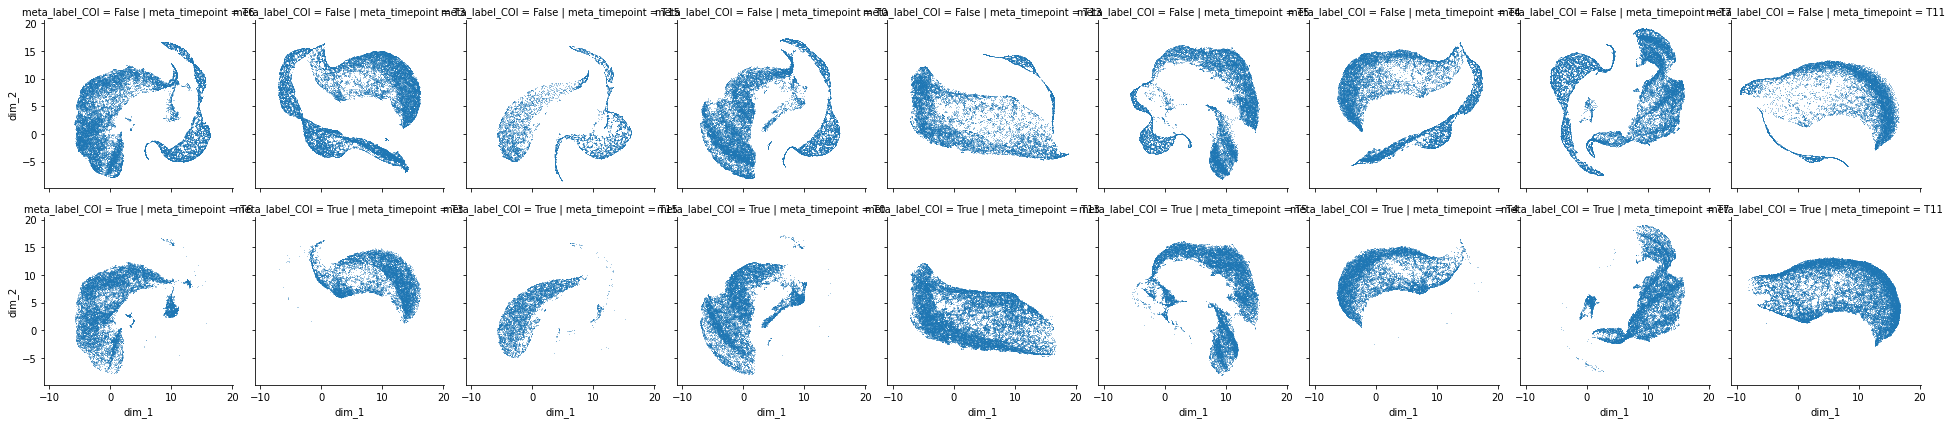

In [21]:
grid = seaborn.FacetGrid(col="meta_timepoint", row="meta_label_COI", data=projected.reset_index(drop=True))
grid = grid.map(plt.scatter, "dim_1", "dim_2", s=0.5, linewidths=0, edgecolors=None, alpha=0.5)
grid.add_legend()

for handle in grid._legend.legendHandles:
    handle.set_sizes([30])
    handle.set_alpha(1.0)
    
# plt.savefig("figs/umap/HTR_Ctrl_ALL.png")

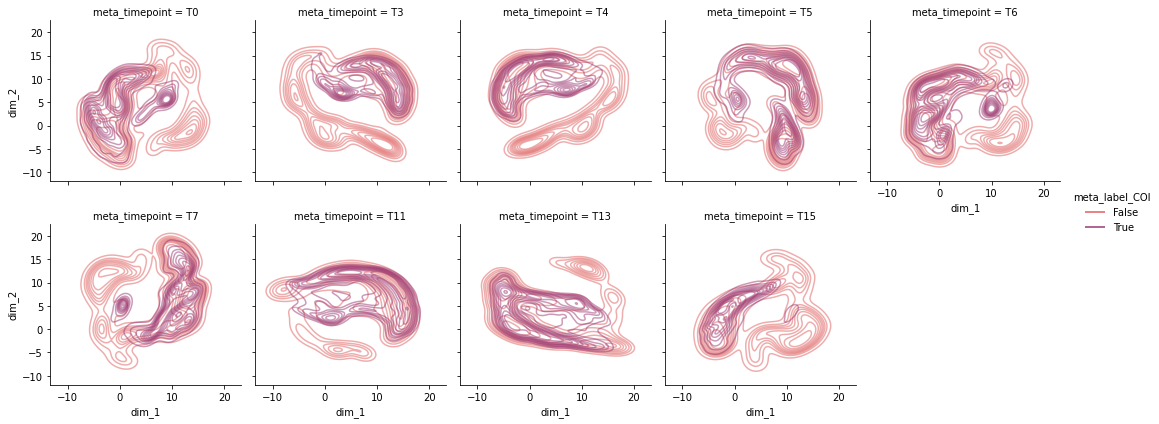

In [19]:
grid = seaborn.FacetGrid(col="meta_timepoint", hue="meta_label_COI", data=projected.reset_index(drop=True), col_wrap=5, col_order=["T%d" % i for i in [0, 3, 4, 5, 6, 7, 11, 13 ,15]], palette="flare")
grid = grid.map(seaborn.kdeplot, "dim_1", "dim_2", alpha=0.5)
grid.add_legend()

for handle in grid._legend.legendHandles:
    handle.set_alpha(1.0)
    
plt.savefig("figs/umap/HTR_Ctrl_ALL_pertp_kde.png", dpi=300, transparent=True)

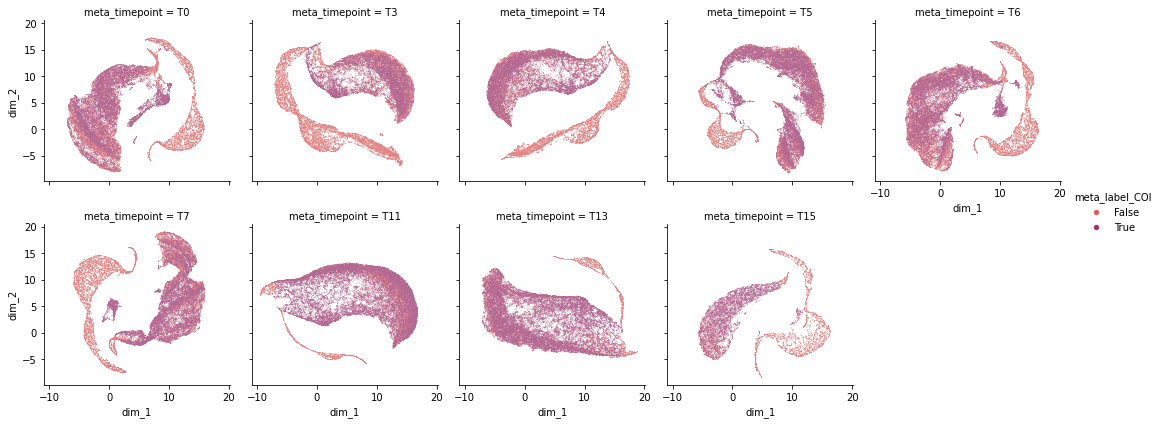

In [16]:
grid = seaborn.FacetGrid(col="meta_timepoint", hue="meta_label_COI", data=projected.reset_index(drop=True), col_wrap=5, col_order=["T%d" % i for i in [0, 3, 4, 5, 6, 7, 11, 13 ,15]], palette="flare")
grid = grid.map(seaborn.scatterplot, "dim_1", "dim_2", s=0.5, linewidths=0, edgecolors=None, alpha=0.5)
grid.add_legend()

for handle in grid._legend.legendHandles:
    handle.set_sizes([30])
    handle.set_alpha(1.0)
    
plt.savefig("figs/umap/HTR_Ctrl_ALL_pertp_scatter.png", dpi=300, transparent=True)

# High samples

In [35]:
%%time
projected = data_dd[data_dd["meta_group"] == "High"].groupby("meta_timepoint").apply(do_umap, n_components=2, meta=meta_df).compute()

CPU times: user 2min 37s, sys: 9.56 s, total: 2min 47s
Wall time: 8min 35s


In [36]:
dump(projected, "data/umap/HTR_High_ALL_pertp.dat")

['data/umap/HTR_High_ALL_pertp.dat']

In [21]:
projected = load("data/umap/HTR_High_ALL_pertp.dat")

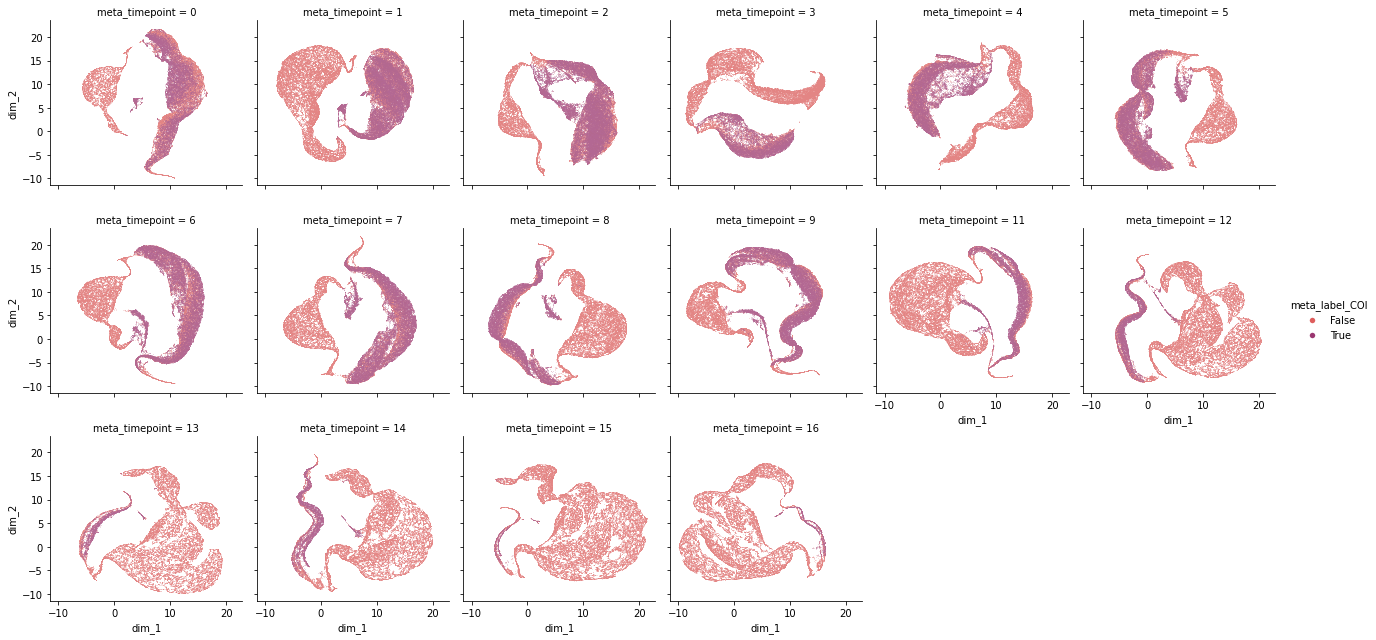

In [48]:
grid = seaborn.FacetGrid(col="meta_timepoint", hue="meta_label_COI", data=projected.reset_index(drop=True), col_wrap=6, palette="flare")
grid = grid.map(seaborn.scatterplot, "dim_1", "dim_2", s=0.5, linewidths=0, edgecolors=None, alpha=0.5)
grid.add_legend()

for handle in grid._legend.legendHandles:
    handle.set_sizes([30])
    handle.set_alpha(1.0)
    
plt.savefig("figs/umap/HTR_High_ALL_pertp_scatter.png", dpi=300, transparent=True)

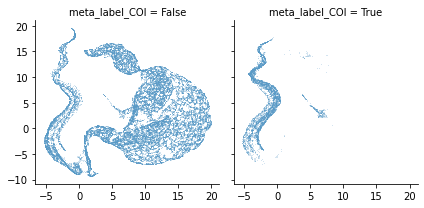

In [47]:
grid = seaborn.FacetGrid(data=projected[projected["meta_timepoint"] == 14], col="meta_label_COI")
grid.map_dataframe(seaborn.scatterplot, data=projected[projected["meta_timepoint"] == 5], x="dim_1", y="dim_2", s=0.5, linewidths=0, edgecolors=None, alpha=0.5, palette="flare")
plt.savefig("figs/umap/HTR_High_ALL_tp14_scatter.png", dpi=300, transparent=True)